In [15]:
from groo.groo import get_root
root_dir = get_root(".root_dir_covid")
import os
import sys
sys.path.append(os.path.join(root_dir, "covid-fear", "scripts"))

import numpy as np
import pandas as pd
from cov_functions import *
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import bambi as bmb
import arviz as az
import json
import pickle
import cov_model_management as mm
import patsy


In [16]:
# data import
df = pd.read_csv(os.path.join(root_dir, "data", "full_dataset_only_complete.csv"))

# Impact of past severity on state measures

In [17]:
### Meta parameters
corr_type = "pearson" # used in all analyses

no_covid_factors = 3
if no_covid_factors ==6:
    factors =[ "F1_Close_Person_Worry","F2_Anxiety_Avoidance", "F3_Economic_Impact_Worry", "F4_Prob_Estimates", "F5_Worry", "F6_Skepticism"]
elif no_covid_factors==3:
    factors = ["F1_CovidAnxietyWorry", "F2_CovidProbabilityEsts", "F3_Economic"]
    
print("State seveirty NaNs: "+str(df["state_severity"].isna().sum())+" out of entries: "+ str(df.shape[0]))

no_trait_factors = 3
if no_trait_factors == 6:
        trait_factor_names = ["TF1_Self_Consciousness", "TF2_Positive", "TF3_Catastrophizing",  "TF4_Physiological_Anx",  "TF5_Depression",  "TF6_Cognitive_Anx"]
elif no_trait_factors==5:
    trait_factor_names = ["TF1_Worry", "TF2_Self_Worth", "TF3_Catastrophizing",  "TF4_Anxiety",  "TF5_Depression"]    
elif no_trait_factors==3:
        trait_factor_names = ["TF3_NegativeAffect", "TF2_PhysiolAnx", "TF1_CognAnxDepr"]
elif no_trait_factors==44:
        trait_factor_names = ["TF3_NegativeAffect", "TF2_PhysiolAnx", "TF1_CognAnxDepr","stai_ta", "sticsa_ta"]
elif no_trait_factors==99:
    trait_factor_names = ["stai_ta", "sticsa_ta", "cat", "bdi"] 



State seveirty NaNs: 198 out of entries: 5825


### Determine best window length
Usign aics isn't the best because data change
R2 seems to just increase (overfitting?) well at window = 9 the number of parameters is the same as data points so the fit is perfect

In [18]:
data = df.groupby(by="PROLIFICID")[["PROLIFICID"]+trait_factor_names].mean()
for tf in trait_factor_names:
    data[tf+"_ts"] = pd.qcut(data[tf], [0, .33, .66, 1],labels=['low', 'mid', 'high'])
    data[tf+"_ms"] = pd.qcut(data[tf], [0, .5, 1],labels=['low', 'high'])
    

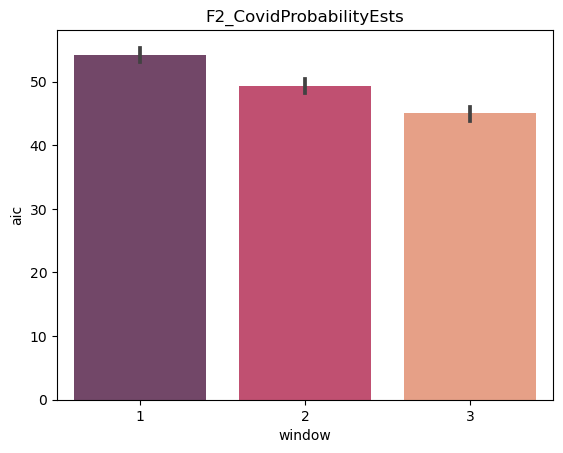

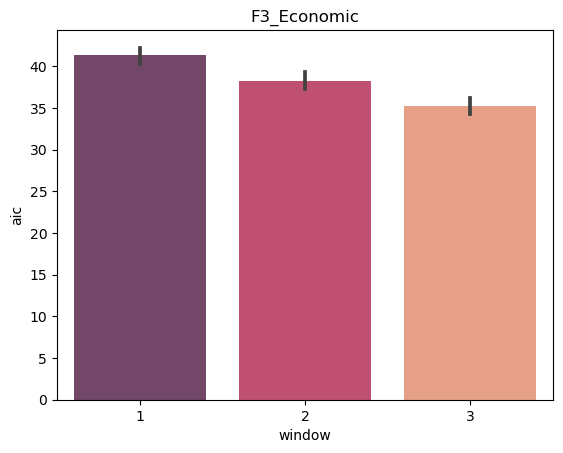

In [19]:
# flip in time, predict t1 with t234 etc
plot_var = "aic"
maxwin = 3
for f in factors:
    fdf = pd.DataFrame()
    
    for w in range(1,maxwin+1):
        tdf = df.groupby(by="PROLIFICID")[["state_severity", f]].apply(run_VAR_single, f, "state_severity", w).reset_index()
        tdf = tdf.loc[:,["PROLIFICID", plot_var]]
        tdf.loc[:,"window"] = str(w)
        tdf = tdf.set_index("PROLIFICID")
        tdf = tdf.join(data) 
        fdf = pd.concat([fdf, tdf])
        
    # plot R2 as a function of window size
    fig = plt.figure()
    #sns.stripplot(x="timepoint", y="beta",
    #              data=tdf_long, dodge=True, alpha=.15, zorder=1, palette=sns.color_palette("rocket", 3));
    sns.barplot(x="window", y=plot_var,
                      dodge=True, data=fdf, alpha=.85, ci=68, 
                      zorder=1, palette=sns.color_palette("rocket", maxwin))
    plt.title(f)
        
    

In [20]:
fdf

aic window  TF3_NegativeAffect  TF2_PhysiolAnx  \
PROLIFICID                                                               
01S0stEpc3rU6YxK  44.681881      1           -0.270737       -0.592381   
05c9AaLx1V20UAcO  46.696866      1           -1.495914        1.133909   
07GDvN1Nh0oHcEBM  52.456825      1           -0.437732       -0.394696   
0OjnLzK5ABd2wO54  26.586557      1           -0.298534        0.597397   
0Pe1blVigsBRLvBj  56.136888      1           -0.374222       -0.062450   
...                     ...    ...                 ...             ...   
zNbLeZqHa6wNHRLR  44.543097      3           -1.342296       -0.386679   
zYWr4nlB9BwdVWFB  29.884622      3            0.105969        0.222751   
zZGJnUM65XIz0F0X  60.577732      3           -0.652928       -0.210182   
zlOEoLWEAwlLTGbE  24.834674      3            0.664146        0.676987   
ztPVSoIVH3QKpGeQ  59.785285      3           -1.453888        0.372510   

                  TF1_CognAnxDepr TF3_NegativeAffect_ts TF3_NegativeAffect_ms  \
PROLIFICID                                                                      
01S0stEpc3rU6YxK        -0.262363                   mid                   low   
05c9AaLx1V20UAcO         0.282148                   low                   low   
07GDvN1Nh0oHcEBM        -0.119848                   mid                   low   
0OjnLzK5ABd2wO54        -1.489741                   mid                   low   
0Pe1blVigsBRLvBj         0.093516                   mid                   low   
...                           ...                   ...                   ...   
zNbLeZqHa6wNHRLR        -0.850063                   low                   low   
zYWr4nlB9BwdVWFB        -0.049860                   mid                  high   
zZGJnUM65XIz0F0X        -0.444112                   low                   low   
zlOEoLWEAwlLTGbE         0.229133                  high                  high   
ztPVSoIVH3QKpGeQ        -0.411546                   low                   low   

                 TF2_PhysiolAnx_ts TF2_PhysiolAnx_ms TF1_CognAnxDepr_ts  \
PROLIFICID                                                                
01S0stEpc3rU6YxK               low               low                mid   
05c9AaLx1V20UAcO              high              high               high   
07GDvN1Nh0oHcEBM               mid               low                mid   
0OjnLzK5ABd2wO54              high              high                low   
0Pe1blVigsBRLvBj               mid              high                mid   
...                            ...               ...                ...   
zNbLeZqHa6wNHRLR               mid               low                low   
zYWr4nlB9BwdVWFB               mid              high                mid   
zZGJnUM65XIz0F0X               mid               low                mid   
zlOEoLWEAwlLTGbE              high              high               high   
ztPVSoIVH3QKpGeQ              high              high                mid   

                 TF1_CognAnxDepr_ms  
PROLIFICID                           
01S0stEpc3rU6YxK                low  
05c9AaLx1V20UAcO               high  
07GDvN1Nh0oHcEBM               high  
0OjnLzK5ABd2wO54                low  
0Pe1blVigsBRLvBj               high  
...                             ...  
zNbLeZqHa6wNHRLR                low  
zYWr4nlB9BwdVWFB               high  
zZGJnUM65XIz0F0X                low  
zlOEoLWEAwlLTGbE               high  
ztPVSoIVH3QKpGeQ                low  

[900 rows x 11 columns]

### State severity on its own

Here, we are asking the question of how much does the state severity of previous time points impact the state factors 

In [21]:
### Meta parameters
window = 5 # two trials back
labels = ['t_min'+str(x) for x in range(0,window+1,1,)]

In [22]:
# chec for serial ortho

for f in factors:
    tdf = df.groupby(by="PROLIFICID")[["state_severity", f]].apply(run_VAR_single, f, "state_severity", window)
    tdf = tdf.reset_index().drop(columns=["index", "level_1"])
    tdf_long = pd.melt(tdf, id_vars=["PROLIFICID"], value_vars=labels,
                    var_name='timepoint', value_name='beta')

    # plot the above
    fig = plt.figure()
    #sns.stripplot(x="timepoint", y="beta",
    #              data=tdf_long, dodge=True, alpha=.15, zorder=1, palette=sns.color_palette("rocket", 3));
    sns.barplot(x="timepoint", y="beta",
                      dodge=True, data=tdf_long, alpha=.85, ci=68, 
                      zorder=1, palette=sns.color_palette("rocket", window+1))
    plt.title(f)


### State severity and trait factors

In [23]:
sc

''

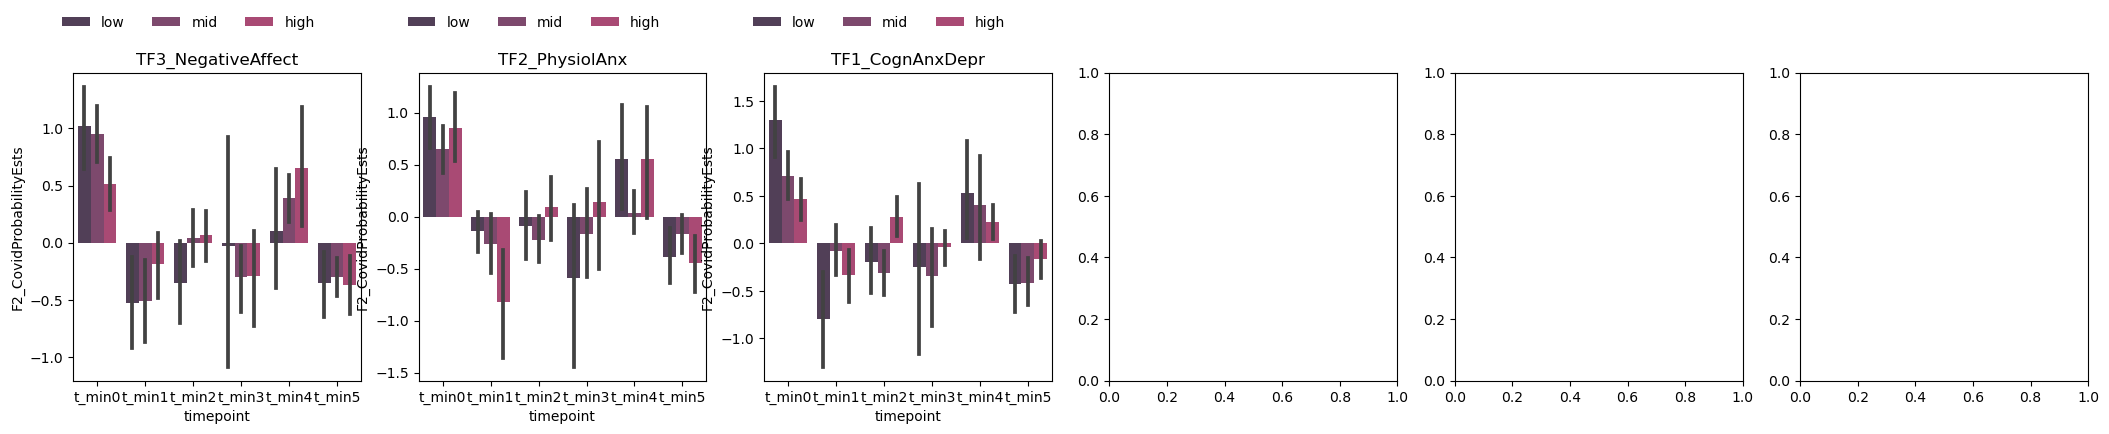

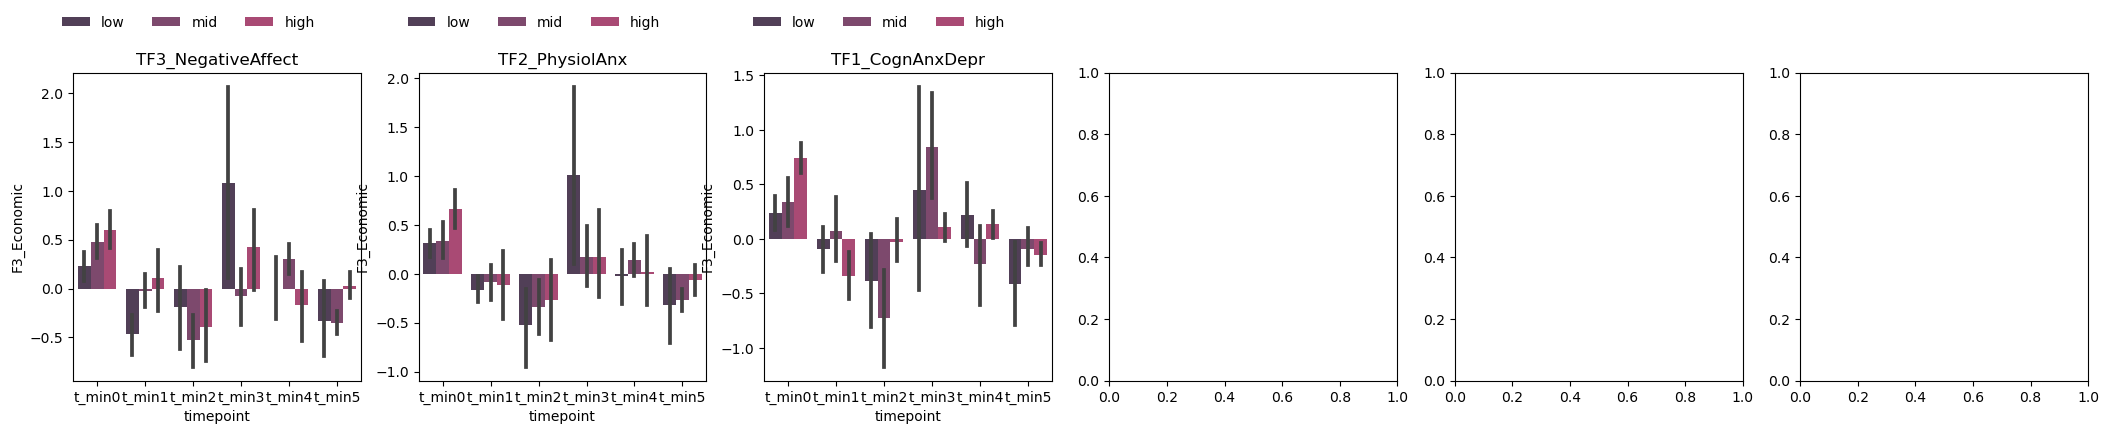

In [24]:


carryfwd = trait_factor_names + [x+"_ts" for x in trait_factor_names]
for f in factors:
    tdf = df.groupby(by="PROLIFICID")[["state_severity", f]].apply(run_VAR_single, f, "state_severity", window)
    tdf = tdf.reset_index().drop(columns=["index", "level_1"]).set_index("PROLIFICID")
    tdf = tdf.join(data).reset_index()
    tdf_long = pd.melt(tdf, id_vars=["PROLIFICID"]+carryfwd, value_vars=labels,
                    var_name='timepoint', value_name='beta')

    # plot the above
    fig, ax = plt.subplots(nrows=1, ncols=6, figsize=(26,4))
    for tf_idx, tf in enumerate(trait_factor_names):
        #sns.stripplot(x="timepoint", y="beta",
        #              data=tdf_long, dodge=True, alpha=.15, zorder=1, palette=sns.color_palette("rocket", 3));
        sns.barplot(x="timepoint", y="beta", hue=tf+"_ts", hue_order=["low", "mid", "high"],
                          dodge=True, data=tdf_long, alpha=.85, ci=68, 
                          zorder=1, palette=sns.color_palette("rocket", window+1), ax=ax[tf_idx])
        sns.move_legend(ax[tf_idx], "lower center", bbox_to_anchor=(0.4, 1.1), ncol=3, title=None, frameon=False)
        #ax[tf_idx].set_xlabel("Correlation with objective severity")
        ax[tf_idx].set_ylabel(f)
        ax[tf_idx].set_title(tf)
        
        

### Change in state severity and state measures

In [25]:
### Meta parameters
window = 2 # two trials back
labels = ['t_min'+str(x) for x in range(0,window+1,1,)]

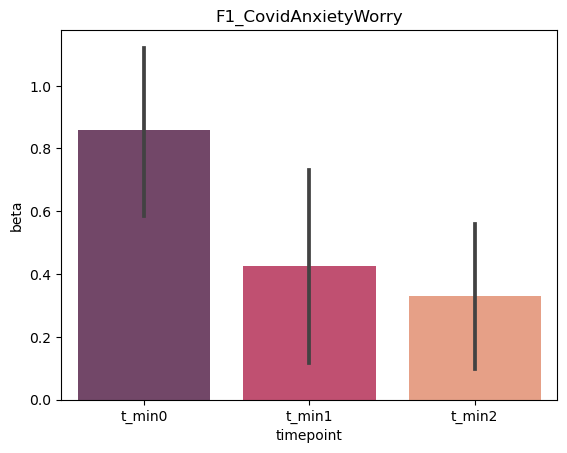

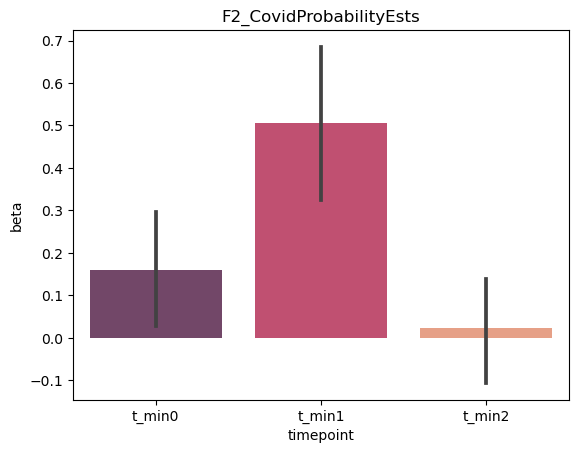

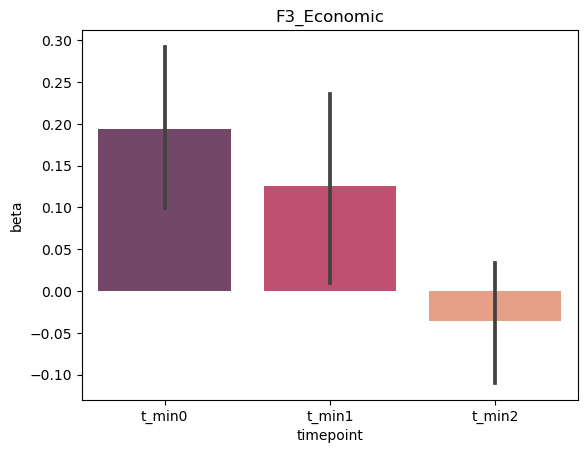

In [26]:


for f in factors:
    tdf = df.groupby(by="PROLIFICID")[["state_severity", f]].apply(run_VAR_single, f, "state_severity", window, "changes")
    tdf = tdf.reset_index().drop(columns=["index", "level_1"])
    tdf_long = pd.melt(tdf, id_vars=["PROLIFICID"], value_vars=labels,
                    var_name='timepoint', value_name='beta')

    # plot the above
    fig = plt.figure()
    #sns.stripplot(x="timepoint", y="beta",
    #              data=tdf_long, dodge=True, alpha=.15, zorder=1, palette=sns.color_palette("rocket", 3));
    sns.barplot(x="timepoint", y="beta",
                      dodge=True, data=tdf_long, alpha=.85, ci=68, 
                      zorder=1, palette=sns.color_palette("rocket", window+1))
    plt.title(f)


### Severity changes and trait measures

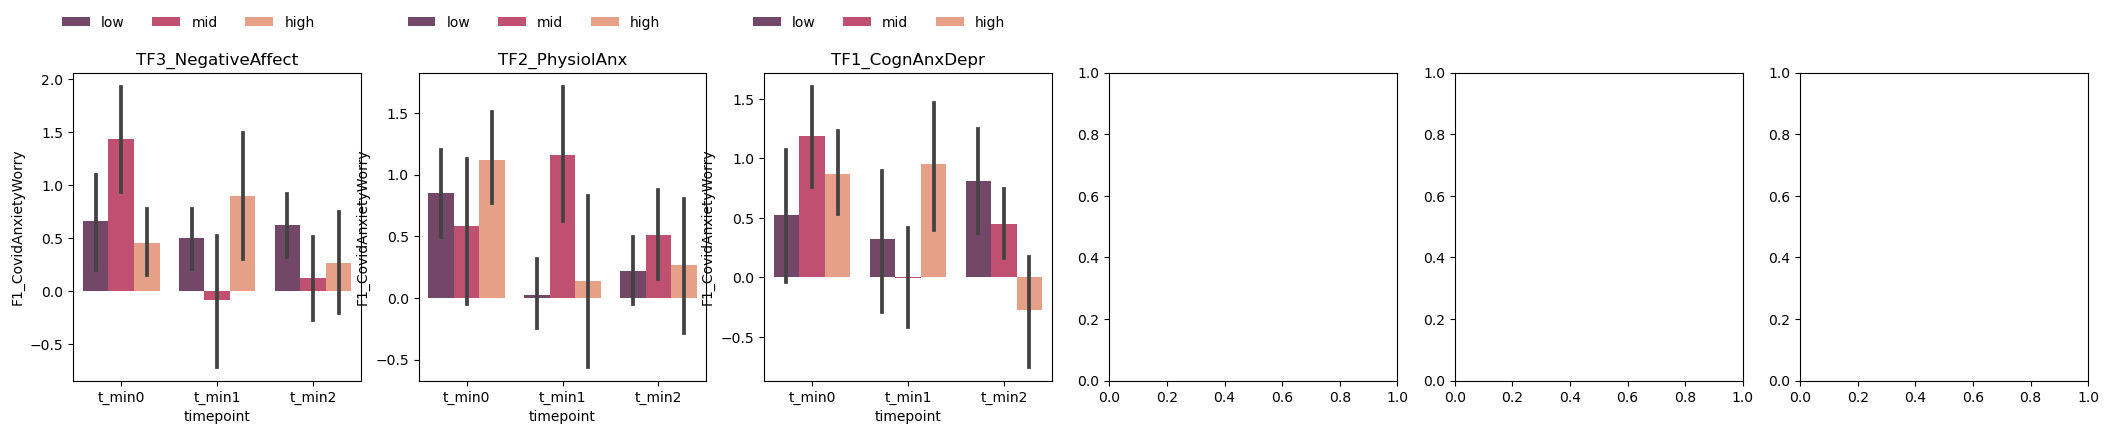

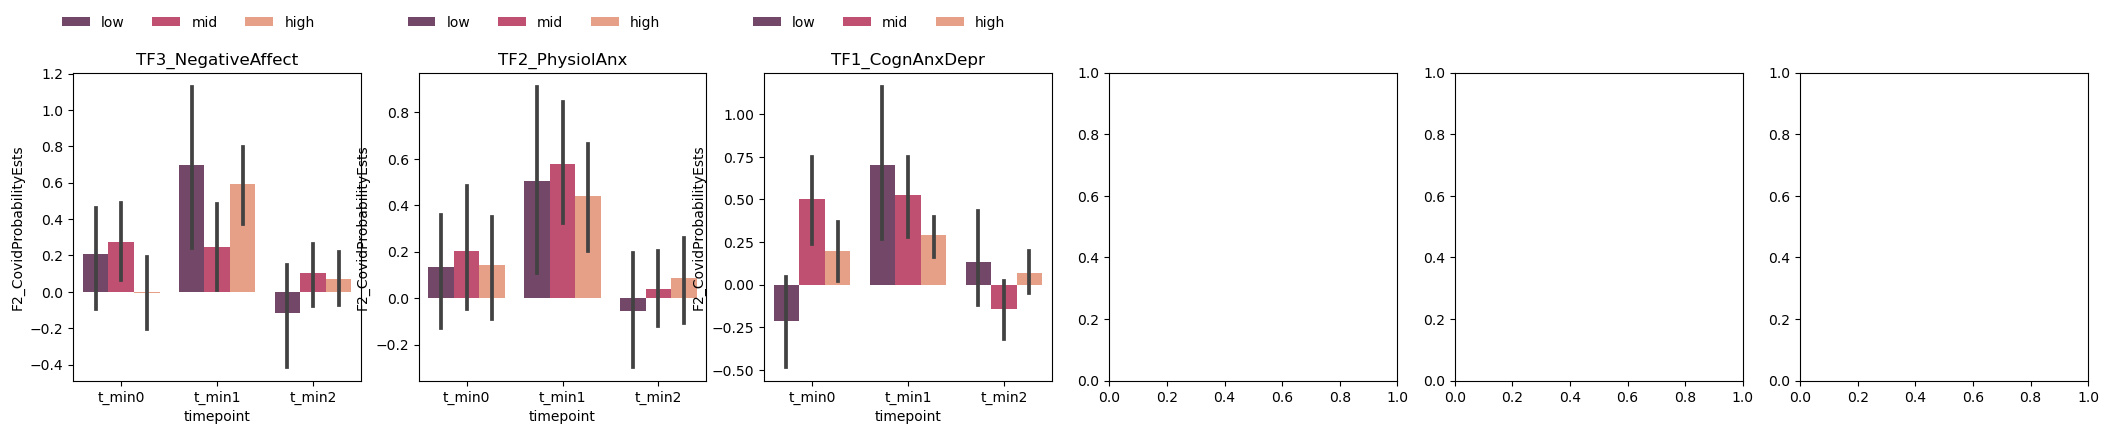

In [27]:
carryfwd = trait_factor_names + [x+"_ts" for x in trait_factor_names]
for f in factors:
    tdf = df.groupby(by="PROLIFICID")[["state_severity", f]].apply(run_VAR_single, f, "state_severity", window, "changes")
    tdf = tdf.reset_index().drop(columns=["index", "level_1"]).set_index("PROLIFICID")
    tdf = tdf.join(data).reset_index()
    tdf_long = pd.melt(tdf, id_vars=["PROLIFICID"]+carryfwd, value_vars=labels,
                    var_name='timepoint', value_name='beta')

    # plot the above
    fig, ax = plt.subplots(nrows=1, ncols=6, figsize=(26,4))
    for tf_idx, tf in enumerate(trait_factor_names):
        #sns.stripplot(x="timepoint", y="beta",
        #              data=tdf_long, dodge=True, alpha=.15, zorder=1, palette=sns.color_palette("rocket", 3));
        sns.barplot(x="timepoint", y="beta", hue=tf+"_ts", hue_order=["low", "mid", "high"],
                          dodge=True, data=tdf_long, alpha=.85, ci=68, 
                          zorder=1, palette=sns.color_palette("rocket", window+1), ax=ax[tf_idx])
        sns.move_legend(ax[tf_idx], "lower center", bbox_to_anchor=(0.4, 1.1), ncol=3, title=None, frameon=False)
        #ax[tf_idx].set_xlabel("Correlation with objective severity")
        ax[tf_idx].set_ylabel(f)
        ax[tf_idx].set_title(tf)

In [28]:
tdf = df.groupby(by="PROLIFICID")[["state_severity", factors[0]]].apply(run_VAR_single, factors[0], "state_severity", 2, "changes").reset_index()